<img style="float: right;" src="Bixi_logo.svg.png" width=200>

In [2]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Timeseries

from statsmodels.tsa.stattools import adfuller

# Connect to SQL database
import sqlite3
connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()

In [4]:
# Import tables

df_bixi = pd.read_sql_query("SELECT * FROM bixi", connex)
df_weather = pd.read_sql_query("SELECT * FROM weather", connex)
df_holiday = pd.read_sql_query("SELECT * FROM holiday", connex)
df_stations = pd.read_sql_query("SELECT * FROM stations",connex)
cur.close()

In [5]:
def describe_df(df):
    print(f'{df.head(2)}\n')
    print(f'{df.info()}\n')
    print(f'shape: {df.shape} \n')
    print(f'Number of null values: \n{df.isnull().sum()}\n')
    print(f'Number of duplicate rows: {df.duplicated().sum()}')

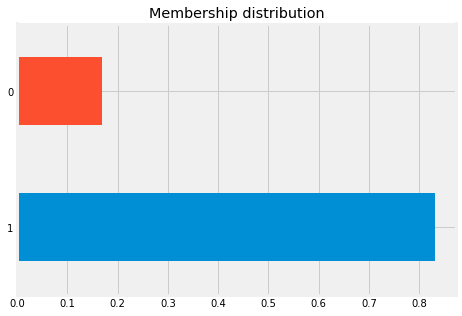

In [6]:
# Membership distribution
df_bixi.is_member.value_counts(normalize = True).plot.barh(title = 'Membership distribution', figsize = (7,5))

1 - Extract from Start_date and End_date date, hour, minute. Add day of the week as feature

In [133]:
# Extract date, hour, minute and day of the week for start date

df_bixi['start_date'] = pd.to_datetime(df_bixi['start_date'])
df_bixi['start_datetime'] = df_bixi['start_date']
df_bixi['start_month'] = df_bixi['start_date'].dt.month
df_bixi['start_hour'] = df_bixi['start_date'].dt.hour
df_bixi['start_weekday'] = df_bixi['start_date'].dt.dayofweek
df_bixi['start_date'] = df_bixi['start_date'].dt.date

# Repeat process for End timestamp

# df_bixi['end_date'] = pd.to_datetime(df_bixi['end_date'])
# df_bixi['end_datetime'] = df_bixi['end_date']
# df_bixi['end_month'] = df_bixi['end_date'].dt.month
# df_bixi['end_hour'] = df_bixi['end_date'].dt.hour
# df_bixi['end_weekday'] = df_bixi['end_date'].dt.dayofweek
# df_bixi['end_date'] = df_bixi['end_date'].dt.date

In [134]:
df_bixi = df_bixi[df_bixi['start_date'] != datetime.date(2018, 4, 10)] # Drop incomplete days
df_bixi = df_bixi[df_bixi['start_date'] != datetime.date(2018, 11, 15)] # Drop incomplete days
df_bixi = df_bixi[df_bixi['duration_sec'] > 120] # Retaining trips longer than 2 minutes
# df_bixi = df_bixi[df_bixi['start_weekday'] < 5] # Retaining trips taken during weekdays
df_bixi = df_bixi.reset_index().drop(['index'], axis = 1) # Reset index

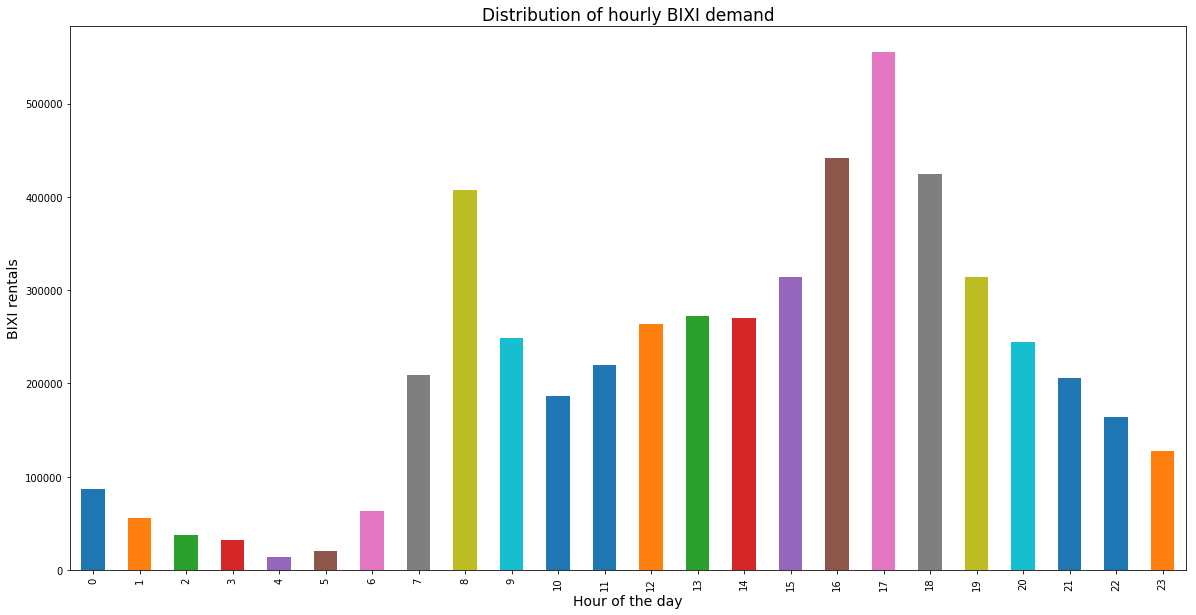

In [136]:
# Demand by hour (0 = From Midnight to 1AM)

grouped_hour = df_bixi.groupby(df_bixi['start_hour']).count().reset_index()
grouped_hour = grouped_hour[['start_hour','start_date']]
grouped_hour.rename(columns = {'start_date':'count'}, inplace = True)
ax_hour = grouped_hour.plot.bar(x = 'start_hour', y = 'count', figsize=(20,10))
ax_hour.set_xlabel('Hour of the day', fontsize=14)
ax_hour.set_ylabel('BIXI rentals', fontsize=14)
ax_hour.set_title("Distribution of hourly BIXI demand", fontsize=17)
ax_hour.get_legend().remove()

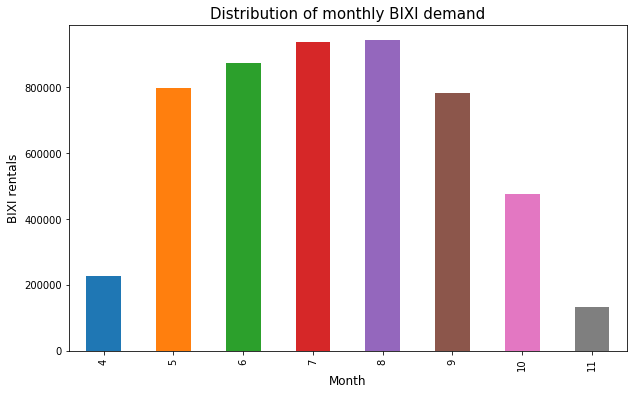

In [137]:
# Average Demand by month
grouped_month = df_bixi.groupby(df_bixi['start_month']).count().reset_index()
grouped_month = grouped_month[['start_month','start_date']]
grouped_month.rename(columns = {'start_date':'count'}, inplace = True)
ax_month = grouped_month.plot.bar(x = 'start_month', y = 'count', figsize=(10,6))
ax_month.set_xlabel('Month', fontsize=12)
ax_month.set_ylabel('BIXI rentals', fontsize=12)
ax_month.set_title("Distribution of monthly BIXI demand", fontsize=15)
ax_month.get_legend().remove()

Text(0.5, 1.0, 'Distribution of BIXI demand by day of the week')

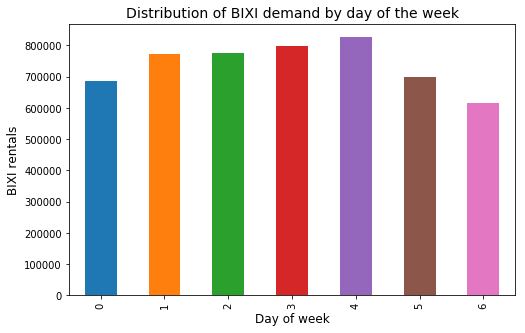

In [138]:
# Demand by day of the week (0 = Monday)

df_by_day = pd.DataFrame(df_bixi.groupby('start_weekday').count()['start_date']).rename(columns = {'start_date':'bixi_rentals'})
ax_day = df_by_day.reset_index().plot.bar(x = 'start_weekday', y = 'bixi_rentals', figsize=(8,5))
ax_day.get_legend().remove()
ax_day.set_xlabel("Day of week", fontsize=12)
ax_day.set_ylabel("BIXI rentals", fontsize=12)
ax_day.set_title("Distribution of BIXI demand by day of the week", fontsize=14)

In [139]:
# To group by date & hour - remove minute granularity
df_bixi['date_hour'] = df_bixi['start_datetime'].apply(lambda x: x.replace(minute=0))

In [20]:
def heat_withtime():
    scaler = MinMaxScaler()
    df_bixi_hm = df_bixi.rename({'start_station_code':'code'}, axis = 1).merge(df_stations)
    df_bixi_hm['count'] = 1
    
    df_hour_list = []
    for hour in list(range(0,24)):
        df = df_bixi_hm.loc[df_bixi_hm.start_hour == hour, ['latitude', 'longitude','count']]
        df = df.groupby(['latitude', 'longitude']).sum()
        df['count'] = scaler.fit_transform(df)
        df_hour_list.append(df.reset_index().values.tolist())

    mtl_coordinates = (45.527616, -73.589115)

    # create empty map
    m = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
    HeatMapWithTime(df_hour_list, index = list(range(0,24)), radius = 15,
                    min_opacity= 0.5, max_opacity=1,
                    gradient={0.001: 'blue', 0.05: 'green', 0.1: 'orange', 0.5: 'red', 0.9: 'darkred'}).add_to(m)
    return m

In [21]:
heat_withtime()

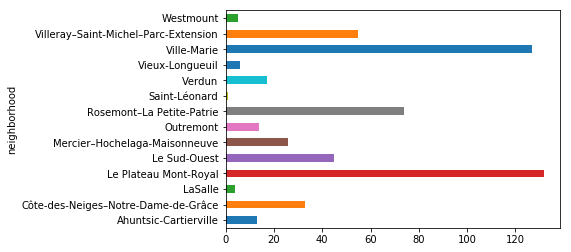

In [22]:
df_stations.groupby('neighborhood').count().code.plot.barh()

In [23]:
# Morning departures

df_morning = df_bixi
# df_bystation = df_bixi.groupby('start_station_code').count().reset_index()
df_morning = df_morning[df_morning['start_hour'] <= 11]
df_morning = df_morning[df_morning['start_hour'] >= 5]

df_mcount = pd.DataFrame(df_morning.groupby('start_station_code').count().sort_values('start_date', ascending = False).start_date)
df_mcount = df_mcount.reset_index().rename({'start_station_code':'code', 'start_date': 'count'}, axis = 1)
df_mcount = df_mcount.merge(df_stations)

# convert to (n, 2) nd-array format for heatmap
arr = df_mcount[['latitude', 'longitude']].values

mtl_coordinates = (45.527616, -73.589115)
  
# create empty map
m = folium.Map(location=mtl_coordinates, zoom_start=11.5, tiles = 'stamenterrain')
 
# add a marker
for row in df_mcount.iterrows():
    folium.CircleMarker(location = [row[1]['latitude'],row[1]['longitude']],
                 popup = row[1]['location'],
                 radius = row[1]['count']/10000,
                 fill=True).add_to(m)
m.add_child(HeatMap(arr, radius=15))
m

In [140]:
df_bixi_byhour = df_bixi.set_index('date_hour').reset_index()
df_bixi_byhour = pd.DataFrame(df_bixi_byhour.groupby('date_hour').count()['start_date']).rename(columns = {'start_date':'bixi_rentals'})
df_bixi_byhour = df_bixi_byhour.asfreq('H')

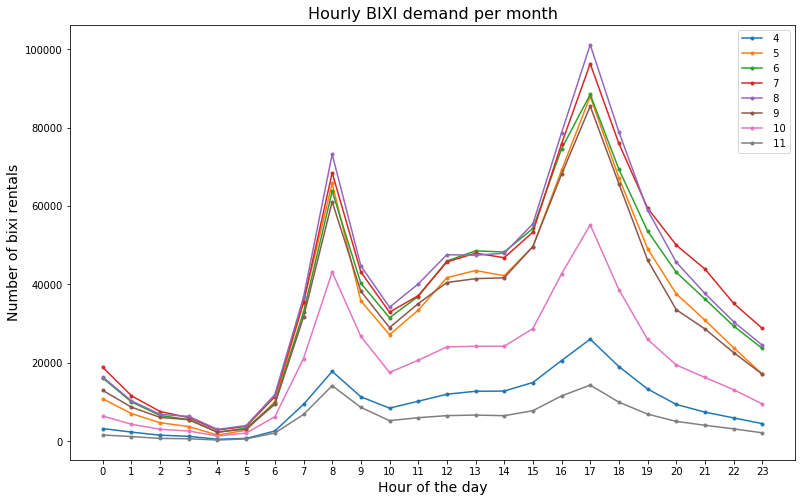

In [25]:
df_mth = df_bixi_byhour.groupby([(df_bixi_byhour.index.hour.values),(df_bixi_byhour.index.month.values)]).sum().unstack()

ax_mth = df_mth.plot(figsize = (13,8),subplots = False, marker = '.')
ax_mth.set_xlabel('Hour of the day', size =14)
ax_mth.set_xticks(range(0,24))
ax_mth.set_ylabel('Number of bixi rentals',size =14)
ax_mth.set_title('Hourly BIXI demand per month', size =16)
handles, labels = ax_mth.get_legend_handles_labels()
labels_new = [label.strip('()').split(',')[1] for label in labels]
plt.legend(handles, labels_new)

Text(0, 0.5, 'Day of the week')

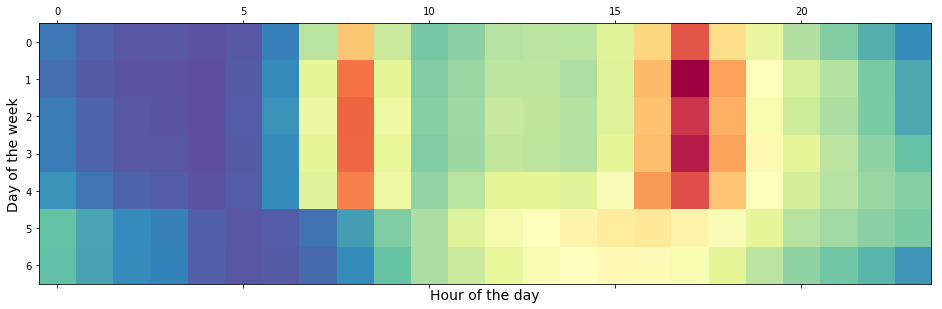

In [483]:
# Day of week usage vs hour of the day

df_day_hour = df_bixi_byhour.groupby([(df_bixi_byhour.index.hour),(df_bixi_byhour.index.dayofweek.values)]).sum().unstack()
plt.matshow(df_day_hour.T, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.xlabel('Hour of the day', size = 14)
plt.ylabel('Day of the week', size = 14)


#### Weather & Holidays

In [303]:
# Converting date_hour column into datetime format
df_weather['date_hour'] = pd.to_datetime(df_weather['date_hour'])

In [304]:
# Cleaning day indicator for 0 or 1 to indicate whether there is daylight
df_weather.day_ind.replace({'N':0, 'D':1}, inplace = True)

In [305]:
# Converting rainfall quantity into indicator of rain
df_weather.precip_hrly = df_weather.precip_hrly.apply(lambda x: 1 if x > 0 else 0)
df_weather.precip_total = df_weather.precip_total.apply(lambda x: 1 if x > 0 else 0)

In [306]:
# df_bixi.drop(['end_station_code','start_datetime','end_date'], axis =1, inplace =True)

In [464]:
df_member = df_bixi.groupby('date_hour').sum()['is_member'].reset_index()
df = df_bixi_byhour.merge(df_weather, on = 'date_hour', how = 'left').merge(df_member, on = 'date_hour', how = 'left')
df['casual'] = df['bixi_rentals'] - df['is_member']

There are missing values for some hours for some days, the prior hour weather description will be used as a proxy as it is the best approximation and all values are necessary to use weather features as exogenous regressors.

In [465]:
# missing some hourly weather data (~120 readings), complete with previous reading
df.bfill(inplace= True)

Weekends have a different usage pattern than week days, therefore creating an indicator is necessary.

In [466]:
# Extracting day of the week from timestamp and indicating if it is the weekend or not
df['is_weekend'] = df['date_hour'].dt.dayofweek
df['is_weekend'] = df['is_weekend'].apply(lambda x: 1 if x >4 else 0)

In [467]:

df_holiday = df_holiday[(df_holiday['holiday_desc'] != "Mother's Day") & (df_holiday['holiday_desc'] != "Father's Day")]
df_holiday.rename(columns = {'holidays':'date'}, inplace = True)

#Converting holiday dates into datetime format
df_holiday.date = pd.to_datetime(df_holiday.date)

# column date to merge on
df['date'] = df.date_hour.dt.date
df.date = pd.to_datetime(df.date)
df = df.merge(df_holiday, on = 'date', how = 'left')

In [468]:
df.holiday_desc = df.holiday_desc.fillna(value = 0)
df.holiday_desc = df.holiday_desc.apply(lambda x: 1 if x !=0 else 0)

In [469]:
df.drop(['date'],axis = 1, inplace = True)

> - To identify which exogenous variables (X) into SARIMAX, looking at the correlation with bike rentals is useful.
> - "Heat index", "feels like", "temp" seem to bring the same information as they are almost perfectly correlated. 
> - "UV index" and "humidity" are also correlated with the number of rentals.
> - Surprisingly, precipitation is not so correlated with bike usage.
> - Another interesting fact is that **casual** members' bike usage is more correlated with temperature, uv_index and whether it rained or not during their rental then **members**!
> - To select which regressor(s) to include in SARIMAX, Random Forest algorithm will be used.

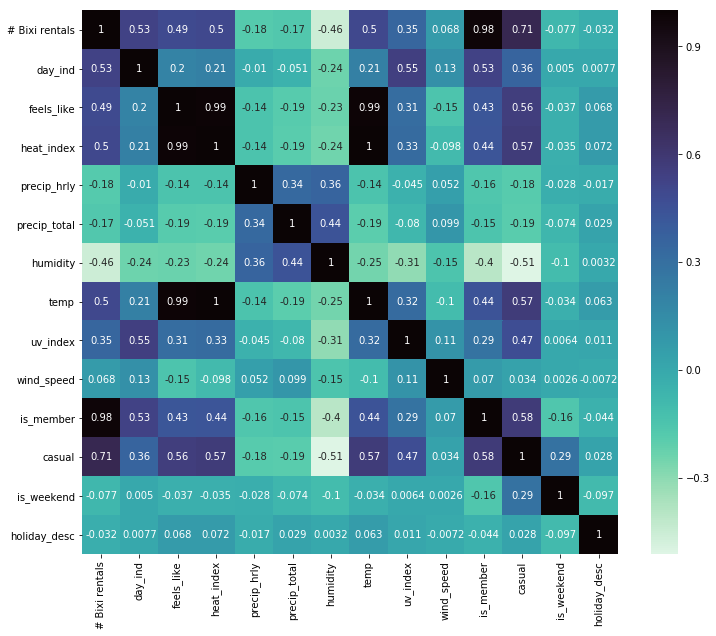

In [470]:
# To identify patterns in usage for casual vs members
# There is a slight difference in behaviour depending on the temperature, heat_index and feels like temperature

plt.figure(figsize = (12,10))
sns.heatmap(df.corr(), annot = True, cmap ='mako_r')

In [471]:
df = df.set_index('date_hour')
df = df.drop(['uv_desc','is_member','casual'],axis = 1)
df.rename(columns = {'holiday_desc':'is_holiday'}, inplace = True)

In [472]:
# Save clean dataframe in new table

connex = sqlite3.connect('bixi_data.db')  
cur = connex.cursor()
df.to_sql(name = 'df_clean', con=connex, if_exists="replace", index=True)  
cur.close()